Train classical convolutional NN on MNIST data set.

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import pickle

In [12]:
NUM_CHANNELS = 1
IMG_SIZE = 28
NUM_LABELS = 10
PIXEL_DEPTH = 255
NUM_EPOCHS = 1
REDUCE_TEST_DATA=0.2
FILTER_DIGITS = False
ZERO_CENTER_DATA = True
SAVE_MODEL = True
LOAD_PICKLE = False

In [13]:
if LOAD_PICKLE:
  test_img_data_col = pickle.load(open('test_img_data_col.pickle', 'rb'))
  N = len(test_img_data_col)
  print(N)

  X = test_img_data_col[0].shape[0]
  Y = test_img_data_col[0].shape[1]

  print(X)
  print(Y)

  x_test_data_col = np.empty((N, X, Y))
  y_test_data_col = np.arange(N)
  print(x_test_data_col.shape)
  print(y_test_data_col.shape)

In [14]:
from tensorflow.keras.datasets import mnist
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print(x_test0.shape)
print(y_test0.shape)

(10000, 28, 28)
(10000,)


Keep only 0, 1, 2

In [15]:
def filter_012(x, y):
    keep = (y == 0) | (y == 1) | (y == 2)
    x, y = x[keep], y[keep]
    #y = y == 3
    return x, y

# Optional filtering
if FILTER_DIGITS:
  print('Filter ON')
  x_train, y_train = filter_012(x_train0, y_train0)
  x_test, y_test = filter_012(x_test0, y_test0)
else:
  print('Filter OFF')
  x_test = x_test0
  y_test = y_test0
  x_train = x_train0
  y_train = y_train0

# Zero-center training and validation data
if ZERO_CENTER_DATA:
  x_train = (x_train - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH
  x_test = (x_test - (PIXEL_DEPTH / 2.0)) / PIXEL_DEPTH

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Filter OFF
Number of filtered training examples: 60000
Number of filtered test examples: 10000


5


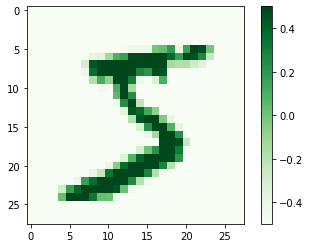

In [16]:
print(y_train[0])

plt.imshow(x_train[0, :, :], cmap='Greens')
plt.colorbar()

Convert train and test images from gray to rgb; and the upscale the images to 32x32 in order to further feed it to the CNN network.

In [17]:
shape_xtr = x_train.shape
x_train = np.reshape(x_train, (-1, shape_xtr[1], shape_xtr[2], 1))
print(x_train.shape)

shape_xt = x_test.shape
x_test = np.reshape(x_test, (-1, shape_xt[1], shape_xt[2], 1))
print(x_test.shape)

y_train = tf.keras.utils.to_categorical(y_train)
print(y_train.shape)
y_test = tf.keras.utils.to_categorical(y_test)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


Create classical CNN model

In [18]:
def create_cnn():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
  model.add(tf.keras.layers.AveragePooling2D())

  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.AveragePooling2D())

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units=120, activation='relu'))

  model.add(tf.keras.layers.Dense(units=84, activation='relu'))

  model.add(tf.keras.layers.Dense(units=NUM_LABELS, activation = 'softmax'))

  return model


model = create_cnn()

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_2 (Average (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               

Fit the model

In [19]:
tf.config.run_functions_eagerly(True)
print(x_train.shape)
print(x_test.shape)
model.fit(x_train, y_train, 
          batch_size=128,
          epochs=NUM_EPOCHS, verbose=1, validation_data=(x_test, y_test))

(60000, 28, 28, 1)
(10000, 28, 28, 1)
  2/469 [..............................] - ETA: 28s - loss: 2.2858 - accuracy: 0.1172

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


469/469 [==============================] - 31s 66ms/step - loss: 0.4160 - accuracy: 0.8791 - val_loss: 0.1500 - val_accuracy: 0.9548


Evaluate the model

In [20]:
cnn_results = model.evaluate(x_test, y_test)

if SAVE_MODEL:
  suffix = ''
  if NUM_EPOCHS == 1:
    suffix = '_epoch'
  else:
    suffix = '_epochs'

  model.save('model_' + str(NUM_EPOCHS) + suffix + '.h5')

  9/313 [..............................] - ETA: 4s - loss: 0.1009 - accuracy: 0.9653

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 5s 15ms/step - loss: 0.1500 - accuracy: 0.9548
